# 导入包

In [29]:
import numpy as np
import pandas as pd
import math
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris # 使用鸢尾花数据集

# 实例一
李航《统计学习方法》P54页例子

数据集：

$T=\{(2,3)^T,(5,4)^T,(9,6)^T,(4,7)^T,(8,1)^T,(7,2)^T\}$

$y=\{1, 1, 0, 1, 0, 0\}$

## 导入数据

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/Statistical-Learning-Method-Python/CH03-kNN/CH03-data1.txt"
df = pd.read_csv(path, header=None, names=["x1", "x2", "y"])
data = np.array(df)

X = data
x = data[:, :data.shape[1]-1]
y = data[:, data.shape[1]-1:data.shape[1]]

## 数据可视化

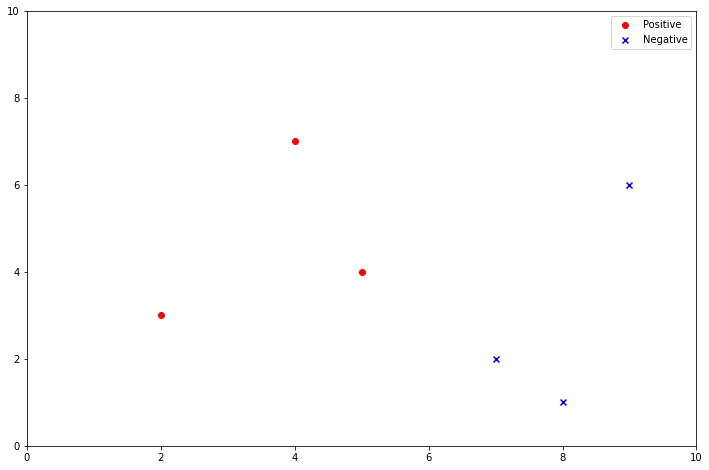

In [5]:
positive = df[df['y'].isin([1])]
negative = df[df['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(positive['x1'], positive['x2'], color="r", marker="o", label="Positive")
ax.scatter(negative['x1'], negative['x2'], color="b", marker="x", label="Negative")
ax.legend()
plt.xticks(np.arange(0, 11, 2))
plt.yticks(np.arange(0, 11, 2))
plt.show()

## 距离度量

### $L_p距离$
公式：
$$
L_p(x_i, x_j)=(\sum_{l=1}^n|x_i^{(l)}-x_j^{(l)}|^p)^{\frac{1}{p}}
$$

In [6]:
def LpDistance(xi, xj, p):
  inner = np.abs(xi - xj)
  power = np.power(inner, p)
  sum = np.sum(power)
  return pow(sum, 1/p)

### 欧式距离
即$L_p$距离中的p=2

公式：
$$
L_2(x_i, x_j)=(\sum_{l=1}^n|x_i^{(l)}-x_j^{(l)}|^2)^{\frac{1}{2}}
$$

In [7]:
def Euclidean(xi, xj):
  inner = np.abs(xi - xj)
  power = np.power(inner, 2)
  sum = np.sum(power)
  return pow(sum, 1/2)

### 曼哈顿距离
即$L_p$距离中的p=1

公式：
$$
L_1(x_i, x_j)=\sum_{l=1}^n|x_i^{(l)}-x_j^{(l)}|
$$

In [8]:
def Manhattan(xi, xj):
  inner = np.abs(xi - xj)
  sum = np.sum(inner)
  return sum

### 当$p=\infty$
距离为各个坐标距离的最大值

公式：
$$
L_\infty(x_i,x_j)=\max_l|x_i^{(l)}-x_j^{(l)}|
$$

In [9]:
def PInfity(xi, xj):
  inner = np.abs(xi - xj)
  mmax = np.max(inner)
  return mmax

## kd树在最近邻(k=1)中的应用

## 树结点的定义

In [16]:
class Node: # 类似链表实现二叉树
  def __init__(self, data, l, left, right):
    # data - 当前结点的样本
    # l - 划分的特征轴
    # left, right - 左右子树区域中的样本信息
    self.data = data
    self.l = l
    self.left = left
    self.right = right

### kd树的构造与最近邻搜索
+ 划分的特征轴$x^{(l)}$，$l=j(mod\ k)+1$

In [17]:
class KdTree():
  def __init__(self, X):
    self.root = self.create(X, 0, X.shape[1] - 1)
    self.bestDist = math.inf
    self.bestNode = None

  def create(self, X, j, k):  # j - 深度；k - 特征个数
    if X.shape[0] == 0:
      return None

    # 计算划分的特征轴
    l = j % k

    # 对当前轮的样本进行排序
    X_sorted = np.array(sorted(X, key=lambda x: x[l]))

    len = X_sorted.shape[0]
    # 找中位数
    mid = len // 2

    data = X_sorted[mid]
    left = X_sorted[:mid]  # 左半区域
    right = X_sorted[mid + 1:]  # 右半区域

    return Node(data, l, self.create(left, j + 1, k), self.create(right, j + 1, k))

  def SearchShortest(self, q, curr_node):
    # q - 待分类结点
    if curr_node == None: return

    dist = Euclidean(q, curr_node.data[:2,])
    if dist < self.bestDist:
      self.bestNode = curr_node.data
      self.bestDist = dist

    haveSearch = -1 # 0 - 搜了左边；1 - 搜了右边
    if curr_node.left != None and q[curr_node.l] < curr_node.data[curr_node.l]:
      self.SearchShortest(q, curr_node.left)
      haveSearch = 0
    elif curr_node.right != None and q[curr_node.l] >= curr_node.data[curr_node.l]:
      self.SearchShortest(q, curr_node.right)
      haveSearch = 1

    if abs(q[curr_node.l] - curr_node.data[curr_node.l]) < self.bestDist:
      if haveSearch:
        self.SearchShortest(q, curr_node.left)
      else:
        self.SearchShortest(q, curr_node.right)

In [27]:
kdtree = KdTree(X)
kdtree.SearchShortest([3, 4.5], kdtree.root)
print("BestNode：", kdtree.bestNode)
print("BestDist：", kdtree.bestDist)

yq = kdtree.bestNode[X.shape[1] - 1]
print("[3, 4.5] 的类别为：", yq)

BestNode： [2 3 1]
BestDist： 1.8027756377319946
[3, 4.5] 的类别为： 1


# 实例二（鸢尾花数据集）

## 导入数据

In [42]:
iris = load_iris()
X2 = iris.get("data") # data - (150, 4)
target = iris.get("target") # target - (150, )
data2 = np.insert(X2, X2.shape[1], values=target, axis=1)

data2

array([[5.1, 3.5, 1.4, 0.2, 0. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. ],
       [5. , 3.6, 1.4, 0.2, 0. ],
       [5.4, 3.9, 1.7, 0.4, 0. ],
       [4.6, 3.4, 1.4, 0.3, 0. ],
       [5. , 3.4, 1.5, 0.2, 0. ],
       [4.4, 2.9, 1.4, 0.2, 0. ],
       [4.9, 3.1, 1.5, 0.1, 0. ],
       [5.4, 3.7, 1.5, 0.2, 0. ],
       [4.8, 3.4, 1.6, 0.2, 0. ],
       [4.8, 3. , 1.4, 0.1, 0. ],
       [4.3, 3. , 1.1, 0.1, 0. ],
       [5.8, 4. , 1.2, 0.2, 0. ],
       [5.7, 4.4, 1.5, 0.4, 0. ],
       [5.4, 3.9, 1.3, 0.4, 0. ],
       [5.1, 3.5, 1.4, 0.3, 0. ],
       [5.7, 3.8, 1.7, 0.3, 0. ],
       [5.1, 3.8, 1.5, 0.3, 0. ],
       [5.4, 3.4, 1.7, 0.2, 0. ],
       [5.1, 3.7, 1.5, 0.4, 0. ],
       [4.6, 3.6, 1. , 0.2, 0. ],
       [5.1, 3.3, 1.7, 0.5, 0. ],
       [4.8, 3.4, 1.9, 0.2, 0. ],
       [5. , 3. , 1.6, 0.2, 0. ],
       [5. , 3.4, 1.6, 0.4, 0. ],
       [5.2, 3.5, 1.5, 0.2, 0. ],
       [5.2, 3.4, 1.4, 0.2, 0. ],
       [4.7, 3

## 数据划分

In [43]:
np.random.shuffle(data2)
trainset = data2[:130]
validationset = data2[130:]

## kd树在k近邻中的应用

## 树结点的定义

In [45]:
class Node: # 类似链表实现二叉树
  def __init__(self, data, l, left, right):
    # data - 当前结点的样本
    # l - 划分的特征轴
    # left, right - 左右子树区域中的样本信息
    self.data = data
    self.l = l
    self.left = left
    self.right = right

### kd树的构造与最近邻搜索
+ 划分的特征轴$x^{(l)}$，$l=j(mod\ k)+1$

In [46]:
class KdTree():
  class BestNodes:
    def __init__(self, bestNode, bestDist):
      self.node = bestNode
      self.dist = bestDist

  def __init__(self, X):
    self.root = self.create(X, 0, X.shape[1] - 1)

  def create(self, X, j, k):  # j - 深度；k - 特征个数
    if X.shape[0] == 0:
      return None

    # 计算划分的特征轴
    l = j % k

    # 对当前轮的样本进行排序
    X_sorted = np.array(sorted(X, key=lambda x: x[l]))

    len = X_sorted.shape[0]
    # 找中位数
    mid = len // 2

    data = X_sorted[mid]
    left = X_sorted[:mid]  # 左半区域
    right = X_sorted[mid + 1:]  # 右半区域

    return Node(data, l, self.create(left, j + 1, k), self.create(right, j + 1, k))

  # def SearchShortest(self, q, curr_node):
  #     self.bestDist = math.inf
  #     self.bestNode = None
  #     self.Search(q, curr_node)
  #
  # def Search(self, q, curr_node):
  #     # q - 待分类结点
  #     if curr_node == None: return
  #
  #     dist = Euclidean(q, curr_node.data[:len(curr_node.data) - 1,])
  #     if dist < self.bestDist:
  #         self.bestNode = curr_node.data
  #         self.bestDist = dist
  #
  #     haveSearch = -1 # 0 - 搜了左边；1 - 搜了右边
  #     if curr_node.left != None and q[curr_node.l] < curr_node.data[curr_node.l]:
  #         self.Search(q, curr_node.left)
  #         haveSearch = 0
  #     elif curr_node.right != None and q[curr_node.l] >= curr_node.data[curr_node.l]:
  #         self.Search(q, curr_node.right)
  #         haveSearch = 1
  #
  #     if abs(q[curr_node.l] - curr_node.data[curr_node.l]) < self.bestDist:
  #         if haveSearch:
  #             self.Search(q, curr_node.left)
  #         else:
  #             self.Search(q, curr_node.right)

  def SearchkNN(self, q, curr_node, k): # k - k近邻
    self.bestNodes = np.array([self.BestNodes(None, math.inf) for i in range(k)])
    self.Search(q, curr_node, k)

  def Search(self, q, curr_node, k):
    # q - 待分类结点
    if curr_node == None: return

    dist = Euclidean(q, curr_node.data[:len(curr_node.data) - 1,])
    index = -1
    for i in range(len(self.bestNodes)) :
      if dist < self.bestNodes[i].dist:
        index = i
        break
    if index != -1:
      self.bestNodes = np.insert(self.bestNodes, index, values=self.BestNodes(curr_node.data, dist))[:k]

    haveSearch = -1 # 0 - 搜了左边；1 - 搜了右边
    if curr_node.left != None and q[curr_node.l] < curr_node.data[curr_node.l]:
      self.Search(q, curr_node.left, k)
      haveSearch = 0
    elif curr_node.right != None and q[curr_node.l] >= curr_node.data[curr_node.l]:
      self.Search(q, curr_node.right, k)
      haveSearch = 1

    if abs(q[curr_node.l] - curr_node.data[curr_node.l]) < self.bestNodes[k - 1].dist:
      if haveSearch:
        self.Search(q, curr_node.left, k)
      else:
        self.Search(q, curr_node.right, k)

In [53]:
kdtree = KdTree(trainset)

## k值的选择（交叉验证）

In [86]:
# 每次重新shuffle才能得到不一样的结果
np.random.shuffle(data2)
trainset = data2[:130]
validationset = data2[130:]

# 训练模型
kdtree = KdTree(trainset)

def ComputeAccuracy(k):
    # cnt = 1 # 记录循环次数
    right = 0
    for va in validationset:
        # print("%d--------" % (cnt))
        kdtree.SearchkNN(va[:len(va) - 1], kdtree.root, k)
        predict = np.zeros(validationset.shape[1] - 1)
        for i in range(k):
            predict[(int)(kdtree.bestNodes[i].node[validationset.shape[1] - 1])] += 1
            # print(kdtree.bestNodes[i].node, kdtree.bestNodes[i].dist)

        y_hat = np.argmax(predict) # 记录最多的标签值（多数表决规则）
        # print(y_hat)
        # cnt += 1

        if (int)(va[len(va) - 1]) == y_hat:
            right += 1

        accuracy = right / len(validationset)
        # print(validationset)

    return accuracy

for k in range(1, 11):
    accuracy = ComputeAccuracy(k)
    print("k = %d, Accuracy：%f" % (k, accuracy))

k = 1, Accuracy：0.950000
k = 2, Accuracy：0.950000
k = 3, Accuracy：0.950000
k = 4, Accuracy：0.900000
k = 5, Accuracy：0.950000
k = 6, Accuracy：0.950000
k = 7, Accuracy：0.950000
k = 8, Accuracy：0.950000
k = 9, Accuracy：1.000000
k = 10, Accuracy：0.950000
